In [1]:
import emcee
import corner
import LC_model
from LC_GenMock import *
%matplotlib inline

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


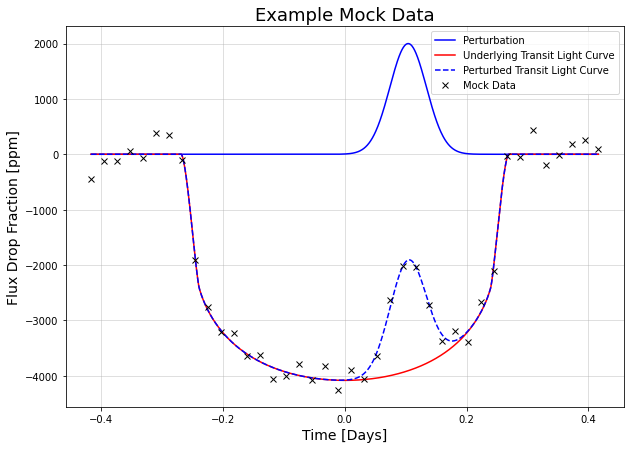

In [2]:
spot_stength = 2000 #ppm
spot_width = 0.03 #days
transit_window = 10 #hours
spot_location = 5/24*0.5 #days
theta_0 = [140.5,0.0576,1.571, 224.22]
ld_coef = [0.47,0.19]
results = generate_mock_data(theta_0,ld_coef,transit_window,
                             spot_location,spot_stength,spot_width)
x_mock, y_mock, x_true, y_true, anomaly, y_anomaly = results
fig = plot_mock_data( *results)

In [3]:
# need this for mcmc input
time = x_mock
flux = y_mock*1e-6+1

In [4]:
# this is for MCMC
def lnprior(theta):
    ap_rs,rp_rs,inc,period,gamma1,gamma2 = theta
    if (10<ap_rs<400 and 0<rp_rs<0.3 and np.pi/2<inc<np.pi/2+0.01 and
         222.5<period<225.72 and gamma1+gamma2<1 and gamma1>0 and gamma2>0):
        return 0.0
    return -np.inf
def lnlike(theta,time,flux,sig):
    """
    Log likelyhood function, least squre model minimization.
    Assuming quadratic limb darkening law.
    """
    fit = LC_model.transit_fit(theta[:-2],theta[-2:],method="quad_ld")
    model = fit.transit_model(time)
    return -np.sum((model-flux)**2/sig**2)  #+ np.log(sig))
def lnprob(theta,args):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta,*args)
def MCMC_run(time,flux,theta,iteration=1000):
    divp = 0.3 #spread on period
    p_min,p_max = theta[3]-divp*5,theta[3]+divp*5
    sig1 = np.zeros(len(time))+1e-6
    ndim, nwalkers = len(theta), 60
    args = [time,flux,sig1]
    p0 = np.random.normal(theta[0],10,nwalkers) #a_p/rs (z0)
    p1 = np.random.normal(theta[1],0.01,nwalkers) #rp/rs (p)
    p2 = np.random.normal(theta[2],0.002,nwalkers) #inc [rad]
    p3 = np.random.normal(theta[3],divp,nwalkers) #period [days]
    p4 = np.random.normal(theta[4],0.05,nwalkers) #gam_1 >0
    p5 = np.random.normal(theta[5],0.05,nwalkers) #gam_2 >0

    pos = np.array([p0,p1,p2,p3,p4,p5]).T
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,args=[args],threads=8)
    pos = sampler.run_mcmc(pos, iteration);
    return sampler.get_chain()

### MCMC stuff 

In [7]:
theta = 140.5,0.0576,np.pi/2+0.005, 224.22,0.47,0.19
sampler = MCMC_run(time,flux,theta,iteration=1000)

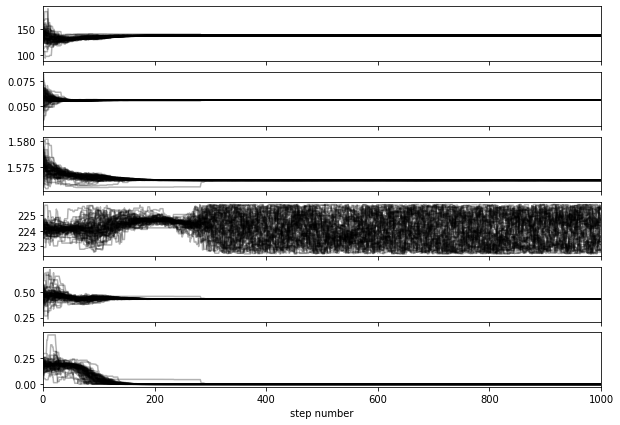

In [8]:
#chain plot
ndim, nwalkers = len(theta), 60
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
axes[-1].set_xlabel("step number");

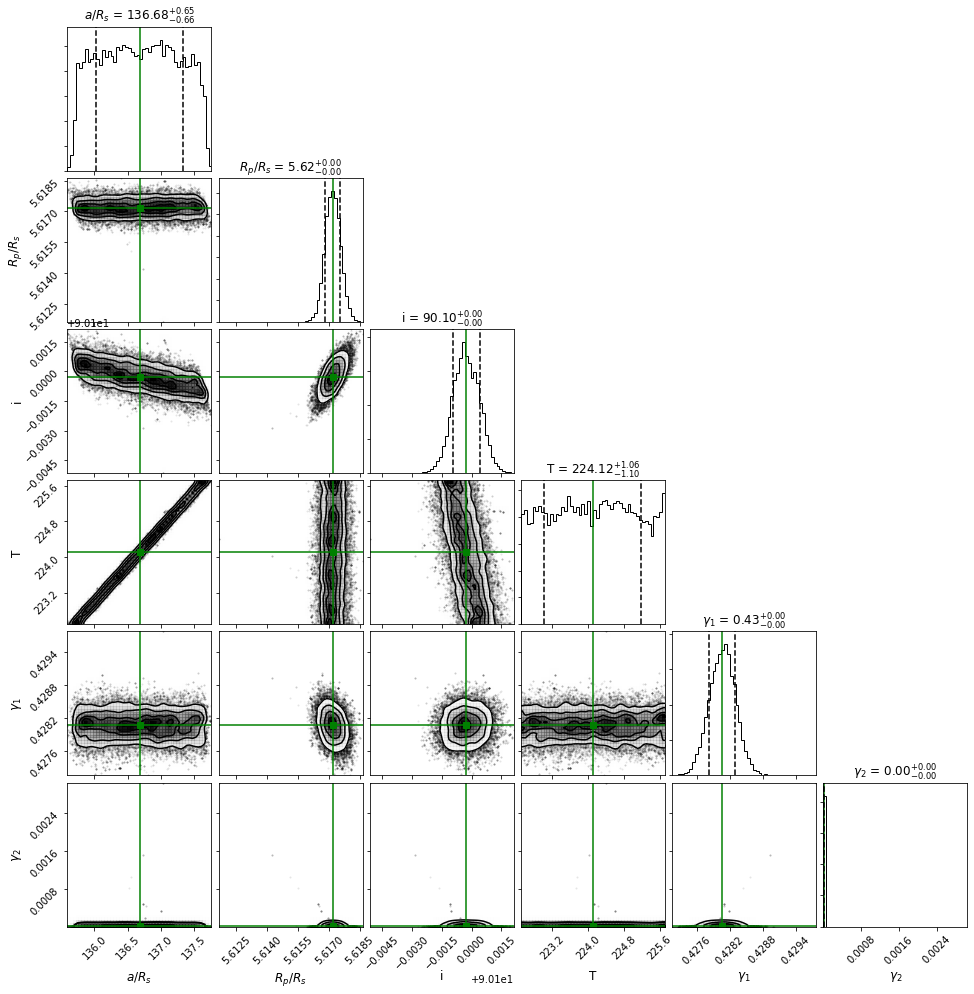

In [9]:
#corner plot
samples = sampler.copy()
#change the 300 to discard more from burn_in
flat_samples = samples[300:,:,:].reshape(-1,ndim) 
flat_samples = flat_samples.T
flat_samples[1] = (flat_samples[1])*100
flat_samples[2] = (flat_samples[2])/2/np.pi*360
# flat_samples[3] = (flat_samples[3]/24/60+period)
lab = [r'$a/R_s$',r'$R_p/R_s$','i','T',r'$\gamma_1$',r'$\gamma_2$']
mcmc = np.percentile(flat_samples, [16, 50, 84],axis=1)
mcmc_th = mcmc[1]
corner.corner(flat_samples.T,bins=50,smooth=True,labels=lab,truth_color='g',label_kwargs={'fontsize':12},
                      truths=mcmc_th, quantiles=[0.16,  0.84],show_titles=True);
# plt.savefig('corner_p.pdf',dpi=1200,tight_layout=True)

In [10]:
# check
flat_samples = samples[:,:,:].reshape(-1,ndim) 
mcmc = np.percentile(flat_samples, [16, 50, 84],axis=1)
mcmc

array([[2.06179721e-01, 1.79481543e-01, 1.58812280e-01, ...,
        3.42307616e-01, 3.42571451e-01, 3.42292048e-01],
       [1.03517080e+00, 1.01526091e+00, 1.03185076e+00, ...,
        4.78580911e+01, 4.78584475e+01, 4.78582381e+01],
       [1.61032660e+02, 1.50649375e+02, 1.51390293e+02, ...,
        1.54180005e+02, 1.53729507e+02, 1.54400359e+02]])

# So if we want to add new clean transits to the data

In [11]:
# this will add 1 clean tranisit to the data, make for loop to have more
spot_stength = 0 #ppm
spot_width = 0. #days
transit_window = 10 #hours
spot_location = 5/24*0.5 #days
theta_0 = [140.5,0.0576,1.571, 224.22]
ld_coef = [0.47,0.19]
results = generate_mock_data(theta_0,ld_coef,transit_window,
                             spot_location,spot_stength,spot_width)
x_mock, y_mock, x_true, y_true, anomaly, y_anomaly = results
# from before flux, time was defined
# as following
# time = x_mock
# flux = y_mock*1e-6+1
time = np.concatenate([time,x_mock])
flux = np.concatenate([flux,y_mock*1e-6+1])
theta = 140.5,0.0576,np.pi/2+0.005, 224.22,0.47,0.19
sampler = MCMC_run(time,flux,theta,iteration=10)

/home/jacob/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1740: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


ValueError: Probability function returned NaN